In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as T
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


# Creating train,val,test sets

## Removing outliers

In [3]:
df = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
# df = pd.merge(df,df_pre, on=['filename','platename','imgname','date','year','plate_idx','location','xtra'])
# df = df[df.knn_outlier==0]
# df = df[df.nb_contours>0]
# print(df.label.unique())

oe = OrdinalEncoder(cols=['label'],mapping=[{'col':'label', 'mapping':{'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10,'other':11}}])
df['txt_label'] = df['label']
df['label'] = oe.fit_transform(df.label)
df.label.value_counts()

9     5820
8     5479
7     4575
4     3025
0     2406
3     2390
10    1874
6     1552
5     1087
2     1026
1      711
11     680
Name: label, dtype: int64

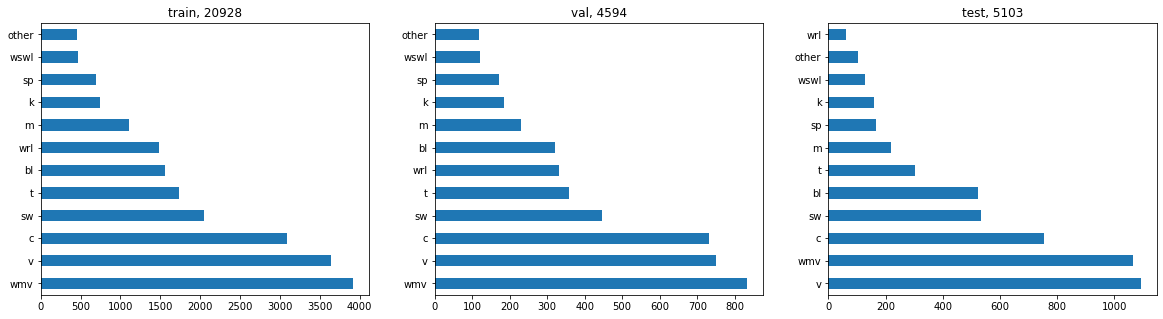

In [4]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(11).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(12).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [5]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [6]:
df_train.to_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val.to_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test.to_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

In [7]:
df_train.label.value_counts()

9     3921
8     3637
7     3092
4     2043
3     1731
0     1563
10    1483
6     1106
5      744
2      689
1      463
11     456
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [8]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
    T.ToPILImage(),
    T.Resize(size=(150,150)),
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAutocontrast(p=0.5),
    T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    T.RandomRotation(degrees=(-15,15)),
    T.RandomPosterize(bits=7, p=0.1),
    # T.RandomEqualize(p=0.5),
    T.ToTensor(),
]

transforms_list_test = [
    T.ToPILImage(),
    T.Resize(size=(150,150)),    
    T.ToTensor(),
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=T.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=T.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=T.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

In [9]:
tensor_image = train_dataset[150][0]
# print(tensor_image)
# plt.imshow(  tensor_image.permute(1, 2, 0)  )
# print(tensor_image.permute(1, 2, 0).shape)

#### Defining the model and training parameters

In [10]:
torch.backends.cudnn.benchmark = True

In [11]:
modelname = "densenet121"
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
                            nn.Linear(num_ftrs,512),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(512, len(topclasses)))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
if modelname.startswith("mobile"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))

In [12]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 150

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(label_smoothing=.25, weight=torch.Tensor(weight).cuda())

Train on gpu: True


In [13]:
optimizer = optim.AdamW(model.parameters(), lr=.003, weight_decay=0.01)#optim.Adam(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0003, max_lr=0.03, cycle_momentum=False, mode="triangular2")

In [14]:
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

# Training

In [15]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    torch.cuda.empty_cache()

    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    with torch.no_grad():
        for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
            pred = model(x_batch)

            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()


    # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}_{setting}")


Training..	: 100%|█| 654/654 [01:27<00:
Validating..	: 100%|█| 144/144 [00:05<0


Epoch 0: train_acc: 54.5% loss: 2.3505340,  val_loss: 1.8249251 val_acc: 68.0%
Validation accuracy improved from 0.00 to 67.98. Saving model..


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 1: train_acc: 66.8% loss: 2.0245275,  val_loss: 1.7562437 val_acc: 67.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 2: train_acc: 69.9% loss: 1.8612411,  val_loss: 1.5862159 val_acc: 71.8%
Validation accuracy improved from 67.98 to 71.77. Saving model..


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 3: train_acc: 71.6% loss: 1.9976370,  val_loss: 1.6645259 val_acc: 74.1%
Validation accuracy improved from 71.77 to 74.10. Saving model..


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 4: train_acc: 73.1% loss: 2.0362792,  val_loss: 1.6783377 val_acc: 74.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 5: train_acc: 73.5% loss: 2.2972002,  val_loss: 1.6659627 val_acc: 72.0%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 6: train_acc: 74.8% loss: 1.9485171,  val_loss: 1.5196570 val_acc: 76.5%
Validation accuracy improved from 74.10 to 76.51. Saving model..


Training..	: 100%|█| 654/654 [01:25<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 7: train_acc: 75.5% loss: 1.7060459,  val_loss: 1.5586739 val_acc: 76.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 8: train_acc: 75.9% loss: 2.3800023,  val_loss: 1.6944118 val_acc: 73.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 9: train_acc: 76.7% loss: 2.4172306,  val_loss: 1.5383925 val_acc: 78.6%
Validation accuracy improved from 76.51 to 78.62. Saving model..


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 10: train_acc: 77.3% loss: 1.5760162,  val_loss: 1.6130569 val_acc: 78.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 11: train_acc: 77.2% loss: 1.6554340,  val_loss: 1.4410977 val_acc: 76.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 12: train_acc: 77.7% loss: 2.1754498,  val_loss: 1.5408003 val_acc: 77.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 13: train_acc: 78.0% loss: 2.1609926,  val_loss: 1.5446463 val_acc: 74.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 14: train_acc: 78.6% loss: 1.8243511,  val_loss: 1.6105556 val_acc: 75.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 15: train_acc: 78.8% loss: 2.3078871,  val_loss: 1.5196830 val_acc: 77.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 16: train_acc: 78.6% loss: 1.9143732,  val_loss: 1.4715989 val_acc: 79.5%
Validation accuracy improved from 78.62 to 79.52. Saving model..


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 17: train_acc: 79.3% loss: 1.8623531,  val_loss: 1.5080647 val_acc: 79.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 18: train_acc: 79.9% loss: 1.7156537,  val_loss: 1.4638188 val_acc: 76.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 19: train_acc: 79.7% loss: 1.8625197,  val_loss: 1.5282050 val_acc: 77.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 20: train_acc: 80.3% loss: 1.9468613,  val_loss: 1.4900575 val_acc: 77.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 21: train_acc: 80.2% loss: 1.8699453,  val_loss: 1.5633353 val_acc: 78.0%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 22: train_acc: 80.7% loss: 2.2455215,  val_loss: 1.5565331 val_acc: 78.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 23: train_acc: 81.2% loss: 1.7186381,  val_loss: 1.5390894 val_acc: 76.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 24: train_acc: 80.5% loss: 1.9196357,  val_loss: 1.5069605 val_acc: 78.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 25: train_acc: 81.2% loss: 1.6974645,  val_loss: 1.6045251 val_acc: 79.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 26: train_acc: 80.8% loss: 1.3824464,  val_loss: 1.5049355 val_acc: 79.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 27: train_acc: 81.7% loss: 1.7965415,  val_loss: 1.4343193 val_acc: 78.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 28: train_acc: 81.5% loss: 1.7103682,  val_loss: 1.5060803 val_acc: 77.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 29: train_acc: 82.4% loss: 2.2250237,  val_loss: 1.4758079 val_acc: 80.9%
Validation accuracy improved from 79.52 to 80.89. Saving model..


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 30: train_acc: 82.1% loss: 1.7277212,  val_loss: 1.4862105 val_acc: 78.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 31: train_acc: 82.4% loss: 2.0416379,  val_loss: 1.4988238 val_acc: 77.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 32: train_acc: 82.2% loss: 1.9242412,  val_loss: 1.4157478 val_acc: 78.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 33: train_acc: 82.8% loss: 1.8426974,  val_loss: 1.6163259 val_acc: 78.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 34: train_acc: 82.7% loss: 1.7414415,  val_loss: 1.4930991 val_acc: 79.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 35: train_acc: 82.9% loss: 1.6924093,  val_loss: 1.4959879 val_acc: 76.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 36: train_acc: 83.2% loss: 1.6757668,  val_loss: 1.5944138 val_acc: 74.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 37: train_acc: 83.2% loss: 2.3573370,  val_loss: 1.5215001 val_acc: 78.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 38: train_acc: 83.3% loss: 1.6225947,  val_loss: 1.5218445 val_acc: 77.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 39: train_acc: 83.8% loss: 2.1464033,  val_loss: 1.4997153 val_acc: 78.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 40: train_acc: 83.5% loss: 2.0401905,  val_loss: 1.5520221 val_acc: 71.0%


Training..	: 100%|█| 654/654 [01:25<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 41: train_acc: 84.2% loss: 1.9867375,  val_loss: 1.4891396 val_acc: 78.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 42: train_acc: 83.9% loss: 1.8696890,  val_loss: 1.4559007 val_acc: 78.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 43: train_acc: 83.7% loss: 2.0684485,  val_loss: 1.4436541 val_acc: 80.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 44: train_acc: 84.2% loss: 2.1177795,  val_loss: 1.4392738 val_acc: 79.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 45: train_acc: 84.2% loss: 1.7651939,  val_loss: 1.4454833 val_acc: 78.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 46: train_acc: 84.3% loss: 1.8399858,  val_loss: 1.4153309 val_acc: 78.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 47: train_acc: 84.1% loss: 1.5253278,  val_loss: 1.5684760 val_acc: 78.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 48: train_acc: 84.5% loss: 1.6144782,  val_loss: 1.4986708 val_acc: 77.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 49: train_acc: 85.0% loss: 2.1002100,  val_loss: 1.5070182 val_acc: 80.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 50: train_acc: 85.3% loss: 1.7980320,  val_loss: 1.4238939 val_acc: 80.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 51: train_acc: 85.2% loss: 1.8972025,  val_loss: 1.4464180 val_acc: 80.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 52: train_acc: 84.7% loss: 1.5890265,  val_loss: 1.5212412 val_acc: 78.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 53: train_acc: 85.2% loss: 1.8499837,  val_loss: 1.4850988 val_acc: 81.0%
Validation accuracy improved from 80.89 to 81.02. Saving model..


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 54: train_acc: 85.5% loss: 1.9334304,  val_loss: 1.4520047 val_acc: 79.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 55: train_acc: 85.2% loss: 1.8184385,  val_loss: 1.4202133 val_acc: 78.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 56: train_acc: 85.2% loss: 1.8170197,  val_loss: 1.5370076 val_acc: 79.0%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 57: train_acc: 85.7% loss: 1.8552239,  val_loss: 1.4624469 val_acc: 80.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 58: train_acc: 85.9% loss: 1.6873492,  val_loss: 1.4948158 val_acc: 77.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 59: train_acc: 85.6% loss: 1.7892637,  val_loss: 1.5622693 val_acc: 75.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 60: train_acc: 84.9% loss: 1.6977906,  val_loss: 1.5664477 val_acc: 79.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 61: train_acc: 86.2% loss: 1.9759785,  val_loss: 1.4763371 val_acc: 80.0%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 62: train_acc: 86.4% loss: 1.9575847,  val_loss: 1.4215771 val_acc: 79.6%


Training..	: 100%|█| 654/654 [01:25<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 63: train_acc: 86.3% loss: 2.0552287,  val_loss: 1.4122803 val_acc: 78.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 64: train_acc: 85.6% loss: 1.7408236,  val_loss: 1.4192497 val_acc: 80.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 65: train_acc: 86.0% loss: 1.8791320,  val_loss: 1.5612509 val_acc: 77.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 66: train_acc: 86.1% loss: 2.0771060,  val_loss: 1.4132231 val_acc: 80.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 67: train_acc: 86.6% loss: 1.7267042,  val_loss: 1.4446788 val_acc: 79.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 68: train_acc: 86.5% loss: 1.6189861,  val_loss: 1.4213817 val_acc: 79.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 69: train_acc: 86.6% loss: 1.7769085,  val_loss: 1.5140646 val_acc: 76.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 70: train_acc: 86.2% loss: 1.6418197,  val_loss: 1.5431091 val_acc: 77.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 71: train_acc: 86.7% loss: 1.7188513,  val_loss: 1.4817555 val_acc: 78.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 72: train_acc: 86.9% loss: 1.5105194,  val_loss: 1.4131289 val_acc: 80.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 73: train_acc: 86.9% loss: 1.6897149,  val_loss: 1.4263259 val_acc: 79.0%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 74: train_acc: 86.8% loss: 1.5811727,  val_loss: 1.4895364 val_acc: 79.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 75: train_acc: 87.2% loss: 1.8635235,  val_loss: 1.5001917 val_acc: 79.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 76: train_acc: 86.8% loss: 1.7811208,  val_loss: 1.5105959 val_acc: 80.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 77: train_acc: 87.5% loss: 2.3104827,  val_loss: 1.4708489 val_acc: 75.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 78: train_acc: 86.8% loss: 1.6445286,  val_loss: 1.4273859 val_acc: 78.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 79: train_acc: 87.6% loss: 1.7143294,  val_loss: 1.4480006 val_acc: 78.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 80: train_acc: 87.3% loss: 2.0392094,  val_loss: 1.4580336 val_acc: 79.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 81: train_acc: 87.4% loss: 2.0894368,  val_loss: 1.5056274 val_acc: 78.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 82: train_acc: 86.8% loss: 1.8650188,  val_loss: 1.5238583 val_acc: 79.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 83: train_acc: 87.2% loss: 1.5362778,  val_loss: 1.4237807 val_acc: 79.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 84: train_acc: 87.5% loss: 1.8525057,  val_loss: 1.4326415 val_acc: 79.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 85: train_acc: 87.4% loss: 1.7535093,  val_loss: 1.7367029 val_acc: 77.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 86: train_acc: 87.8% loss: 1.9446734,  val_loss: 1.5504141 val_acc: 78.0%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 87: train_acc: 87.3% loss: 1.8009651,  val_loss: 1.4567702 val_acc: 80.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 88: train_acc: 87.4% loss: 1.5815837,  val_loss: 1.3980933 val_acc: 79.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 89: train_acc: 87.5% loss: 2.0869951,  val_loss: 1.5839783 val_acc: 78.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 90: train_acc: 88.0% loss: 1.5776503,  val_loss: 1.3985188 val_acc: 81.2%
Validation accuracy improved from 81.02 to 81.19. Saving model..


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 91: train_acc: 88.2% loss: 1.5159806,  val_loss: 1.4209783 val_acc: 80.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 92: train_acc: 87.8% loss: 1.7148533,  val_loss: 1.4657689 val_acc: 78.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 93: train_acc: 88.3% loss: 1.8279647,  val_loss: 1.6352654 val_acc: 73.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 94: train_acc: 87.5% loss: 1.5687904,  val_loss: 1.6166623 val_acc: 77.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 95: train_acc: 87.7% loss: 1.5274887,  val_loss: 1.4093966 val_acc: 76.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 96: train_acc: 87.4% loss: 1.9043381,  val_loss: 1.4826624 val_acc: 78.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 97: train_acc: 87.8% loss: 1.4630888,  val_loss: 1.4125357 val_acc: 80.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 98: train_acc: 87.7% loss: 1.8757455,  val_loss: 1.4800054 val_acc: 74.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 99: train_acc: 88.3% loss: 1.9759365,  val_loss: 1.5094430 val_acc: 76.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 100: train_acc: 88.3% loss: 1.9826243,  val_loss: 1.5067017 val_acc: 77.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 101: train_acc: 88.7% loss: 2.2322874,  val_loss: 1.5648293 val_acc: 79.2%


Training..	: 100%|█| 654/654 [01:23<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 102: train_acc: 88.2% loss: 1.6848235,  val_loss: 1.4034016 val_acc: 79.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 103: train_acc: 87.8% loss: 1.8372383,  val_loss: 1.4472930 val_acc: 79.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 104: train_acc: 88.5% loss: 1.7141945,  val_loss: 1.4263676 val_acc: 78.1%


Training..	: 100%|█| 654/654 [01:26<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 105: train_acc: 88.3% loss: 1.9276781,  val_loss: 1.4390266 val_acc: 76.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 106: train_acc: 88.3% loss: 1.9880056,  val_loss: 1.5406440 val_acc: 76.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 107: train_acc: 88.4% loss: 2.2225413,  val_loss: 1.6694775 val_acc: 77.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 108: train_acc: 88.2% loss: 1.8185264,  val_loss: 1.4618354 val_acc: 76.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 109: train_acc: 89.0% loss: 1.5460798,  val_loss: 1.5305846 val_acc: 80.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 110: train_acc: 88.2% loss: 1.9326576,  val_loss: 1.4296820 val_acc: 79.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 111: train_acc: 88.7% loss: 2.1278558,  val_loss: 1.3930193 val_acc: 81.2%
Validation accuracy improved from 81.19 to 81.24. Saving model..


Training..	: 100%|█| 654/654 [01:23<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 112: train_acc: 88.1% loss: 1.4398339,  val_loss: 1.4130688 val_acc: 81.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 113: train_acc: 88.5% loss: 1.5264101,  val_loss: 1.4259514 val_acc: 78.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 114: train_acc: 88.6% loss: 1.7498826,  val_loss: 1.4049830 val_acc: 78.0%


Training..	: 100%|█| 654/654 [01:23<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 115: train_acc: 88.3% loss: 1.5327880,  val_loss: 1.4141933 val_acc: 77.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 116: train_acc: 88.7% loss: 1.8574402,  val_loss: 1.4456528 val_acc: 79.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 117: train_acc: 88.6% loss: 2.6525416,  val_loss: 1.4303198 val_acc: 80.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 118: train_acc: 89.2% loss: 1.7756131,  val_loss: 1.4311004 val_acc: 79.5%


Training..	: 100%|█| 654/654 [01:23<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 119: train_acc: 88.4% loss: 1.6592938,  val_loss: 1.4376097 val_acc: 78.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 120: train_acc: 89.2% loss: 1.9159464,  val_loss: 1.5477355 val_acc: 76.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 121: train_acc: 88.6% loss: 2.0535965,  val_loss: 1.5574589 val_acc: 76.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 122: train_acc: 88.5% loss: 1.6080563,  val_loss: 1.6925921 val_acc: 76.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 123: train_acc: 88.0% loss: 1.7106125,  val_loss: 1.4129311 val_acc: 80.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 124: train_acc: 89.0% loss: 1.2565166,  val_loss: 1.4333256 val_acc: 77.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 125: train_acc: 88.6% loss: 2.0654457,  val_loss: 1.5871320 val_acc: 76.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 126: train_acc: 88.6% loss: 1.7447336,  val_loss: 1.4107797 val_acc: 79.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 127: train_acc: 89.1% loss: 1.6463773,  val_loss: 1.4377229 val_acc: 79.5%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 128: train_acc: 88.6% loss: 2.2172079,  val_loss: 1.4437958 val_acc: 79.6%


Training..	: 100%|█| 654/654 [01:23<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 129: train_acc: 89.1% loss: 1.7392535,  val_loss: 1.4326713 val_acc: 78.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 130: train_acc: 88.9% loss: 1.5991933,  val_loss: 1.4771683 val_acc: 79.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 131: train_acc: 89.0% loss: 1.4816267,  val_loss: 1.6615506 val_acc: 79.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 132: train_acc: 88.5% loss: 1.7367095,  val_loss: 1.5068376 val_acc: 79.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 133: train_acc: 89.6% loss: 1.9326792,  val_loss: 1.5230370 val_acc: 75.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 134: train_acc: 88.8% loss: 1.9078434,  val_loss: 1.4253923 val_acc: 78.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 135: train_acc: 88.9% loss: 1.8049659,  val_loss: 1.6615537 val_acc: 77.4%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 136: train_acc: 88.8% loss: 1.7125087,  val_loss: 1.4767771 val_acc: 78.3%


Training..	: 100%|█| 654/654 [01:23<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 137: train_acc: 87.7% loss: 1.5399688,  val_loss: 1.5475682 val_acc: 76.1%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 138: train_acc: 88.6% loss: 1.8768928,  val_loss: 1.5363002 val_acc: 79.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 139: train_acc: 89.4% loss: 1.8048842,  val_loss: 1.4399164 val_acc: 78.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 140: train_acc: 89.1% loss: 1.6947227,  val_loss: 1.4295342 val_acc: 79.6%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 141: train_acc: 88.6% loss: 1.6086408,  val_loss: 1.4244452 val_acc: 79.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 142: train_acc: 89.6% loss: 1.9662251,  val_loss: 1.4149625 val_acc: 78.8%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 143: train_acc: 89.1% loss: 1.9570360,  val_loss: 1.4898204 val_acc: 80.0%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 144: train_acc: 89.0% loss: 1.5953959,  val_loss: 1.5400447 val_acc: 76.9%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 145: train_acc: 88.4% loss: 1.8768533,  val_loss: 1.6567824 val_acc: 78.7%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 146: train_acc: 88.6% loss: 1.6602546,  val_loss: 1.5177617 val_acc: 78.0%


Training..	: 100%|█| 654/654 [01:23<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 147: train_acc: 89.0% loss: 1.9198942,  val_loss: 1.7273879 val_acc: 79.3%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 148: train_acc: 89.0% loss: 1.6916890,  val_loss: 1.5668781 val_acc: 75.2%


Training..	: 100%|█| 654/654 [01:24<00:
Validating..	: 100%|█| 144/144 [00:04<0


Epoch 149: train_acc: 89.0% loss: 1.9670072,  val_loss: 1.5189807 val_acc: 75.8%


In [16]:
x_batch[0].shape

torch.Size([3, 150, 150])

In [17]:
train_dataset